In [63]:

import torch
from torch.utils.data import DataLoader

import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

from src.utils import (load_model_and_tokenizer, 
                       load_ms_data,  
                       check_gpu_memory, 
)

import argparse

from transformers import DataCollatorWithPadding, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, AutoModel

from datasets import concatenate_datasets, Dataset

from tqdm import tqdm

from typing import Callable

import json

import outlines

In [5]:
import outlines.models as models

In [6]:
check_gpu_memory()

GPU 0: NVIDIA GeForce RTX 3090
   Total Memory: 23.69 GB
   Free Memory: 23.43 GB
   Allocated Memory : 0.00 GB
   Reserved Memory : 0.00 GB


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# LLAMA MedTuned 13B

In [2]:
MODEL_NAME = "Llama2-MedTuned-13b"
model, tokenizer = load_model_and_tokenizer(model_name = MODEL_NAME,
                                            task_type = "clm",
                                            quantization = "4bit",
                                           # attn_implementation = "flash_attention_2"
                                           )
model.config.use_cache = True
check_gpu_memory()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Tokenizer pad token ID: 32000
Tokenizer special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}
Model pad token ID: 32000
GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 23.41 GB
   Allocated Memory : 7.42 GB
   Reserved Memory : 7.59 GB


In [10]:
labels = ["primary progressive multiple sclerosis", "secondary progressive multiple sclerosis",
          "relapsing remitting multiple sclerosis","not enough info"]

In [13]:
encoded_labels = get_hidden_state([" "], model, tokenizer)

100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


In [3]:
# Load data
df_line = load_ms_data("line")
df_all = load_ms_data("all")
df_first_last = load_ms_data("all_first_line_last")

In [7]:
# Trying to make output more consistent by stopping on MS, https://github.com/huggingface/transformers/issues/26959
class EosListStoppingCriteria(StoppingCriteria):
    def __init__(self, eos_sequence = [835, 2799, 4080, 29901]):
        self.eos_sequence = eos_sequence

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        last_ids = input_ids[:,-len(self.eos_sequence):].tolist()
        return self.eos_sequence in last_ids
ms_stop = EosListStoppingCriteria(tokenizer("multiple sclerosis", add_special_tokens = False)["input_ids"])

In [5]:
generation_config = GenerationConfig(bos_token_id = tokenizer.bos_token_id,
                                     eos_token_id = tokenizer.eos_token_id,
                                     pad_token_id = tokenizer.pad_token_id,
                                     use_cache = True,
                                     max_new_tokens = 20,
                                     temperature=1,
                                     top_p=1,
                                     do_sample=False,
                                     output_hidden_states = False,
                                     return_dict_in_generate = True,
                                    )

def single_round_inference(reports:list[str], 
                           model:AutoModelForCausalLM, 
                           tokenizer:AutoTokenizer, 
                           format_fun:Callable[[str],str], 
                           generation_config:GenerationConfig = None,
                           prefix:str = "[/INST]",
                           device:torch.device = torch.device("cpu"),
                           batch_size:int=1,
                           output_hidden_states:bool = True)->dict:
    
    """ Single round inference for the MS extraction task
    
    Args:
        reports (list[str]): list of medical reports
        model (AutoModelForCausalLM): model
        tokenizer (AutoTokenizer): tokenizer
        format_fun (Callable[[str],str]): function to convert input text to desired prompt format
        generation_config (GenerationConfig): generation config. Defaults to None. If None, default config is used.
        prefix (str): prefix that separates input from output. Defaults to "[/INST]".
        device (torch.device): device. Defaults to torch.device("cpu").
        batch_size (int): batch size. Defaults to 1.
        output_hidden_states (bool); whether hidden states should be calculated for model answers. Defaults to True
        
    Returns:
        dict: dictionary with keys report, prediction, last_hidden_states, input_lengths, whole_prompt
            
    """
    print("Starting Inference")
    tokens = [tokenizer(format_fun(t), add_special_tokens = False, truncation = True) for t in reports]
    
    collate_fn = DataCollatorWithPadding(tokenizer, padding=True)

    dataloader = DataLoader(dataset=tokens, collate_fn=collate_fn, batch_size=batch_size, shuffle = False) 

    model.eval()

    results = []
    whole_prompt = []
    last_hidden_states = []
    input_lengths = [len(t["input_ids"]) for t in tokens]

    for idx, batch in enumerate(tqdm(dataloader)):
        batch.to(device)
        with torch.no_grad():
            outputs = model.generate(
                **batch,
                generation_config=generation_config,
            )

        # Check GPU memory every 5 batches
        if idx % 5 == 0:
            check_gpu_memory()


        return_tokens = outputs["sequences"].to("cpu")
        batch_result = tokenizer.batch_decode(return_tokens, skip_special_tokens=True)
        batch_result = [" " if result == "" else result for result in batch_result]
        whole_prompt.extend(batch_result)
        batch_result = [" " if result == "" else result.split(prefix)[-1].lower().strip() for result in batch_result]
        print("batch results ", batch_result)

        print(batch_result)

        results.extend(batch_result)
        del outputs
        torch.cuda.empty_cache()

    print("Finished Inference")

    if output_hidden_states:
        # This separate pass is not time but memory efficient as if the hidden states are calculated during inference,
        # hidden states are calculated for every token in the batch and the generated sequence.
        print("Starting Hidden State Calculation")
        last_hidden_states = get_hidden_state(results, model, tokenizer, device, batch_size)
        print("Finished Hidden State Calculation")

    else:
        last_hidden_states = None

        
    return {"report": reports, 
            "prediction": results, 
            "last_hidden_states": last_hidden_states, 
            "input_lengths":input_lengths,
            "whole_prompt": whole_prompt}

def multi_round_inference(reports:list[str], 
                          model:AutoModelForCausalLM, 
                          tokenizer:AutoTokenizer, 
                          format_fun1:Callable[[str],str],
                          format_fun2:Callable[[str],str],
                          generation_config:GenerationConfig = None,
                          prefix:str = "[/INST]",
                          device:torch.device = torch.device("cpu"),
                          batch_size:int = 1)->dict:
    
    """Multi Round inference for the MS extraction task
    
    Args:
        reports (list[str]): list of medical reports
        model (AutoModelForCausalLM): model
        tokenizer (AutoTokenizer): tokenizer
        format_fun1 (Callable[str,str]): function to convert input text to desired prompt format
        format_fun2 (Callable[str,str]): function to convert chat history to desired prompt format
        generation_config (GenerationConfig): generation config. Defaults to None. If None, default config is used.
        prefix (str): prefix that separates input from output. Defaults to "[/INST]".
        device (torch.device): device. Defaults to torch.device("cpu").
        batch_size (int): batch size. Defaults to 1.
        
    Returns:
        dict: dictionary with keys report, prediction, last_hidden_states, input_lengths, whole_prompt
            
    """
    
    max_new_tokens = generation_config.max_new_tokens

    # For first round don't calculate hidden states and use long max_new_tokens, and low batch size
    generation_config.max_new_tokens = 100
    output_round1 = single_round_inference(reports=reports,
                                           model=model, 
                                           tokenizer=tokenizer, 
                                           format_fun=format_fun1,
                                           generation_config=generation_config,
                                           device=device,
                                           batch_size=1,
                                           output_hidden_states=False)

    # For second round calculate hidden states if desired
    generation_config.max_new_tokens = max_new_tokens
    chat_history = output_round1["whole_prompt"]
    chat_history = [text.split("[/INST]")[-1] for text in chat_history]

    return single_round_inference(reports=chat_history,
                                  model=model, 
                                  tokenizer=tokenizer, 
                                  format_fun=format_fun2,
                                  generation_config=generation_config,
                                  prefix=prefix,
                                  device=device,
                                  batch_size=batch_size,
                                  output_hidden_states=True)



def get_hidden_state(text: list[str], model:AutoModel, tokenizer:AutoTokenizer, device:torch.device=torch.device("cpu"), batch_size:int = 16)->list[torch.Tensor]:
    """Get hidden state of last layer of model for each prediction in results. Per default the last 
    
    Args:
        text (list[str]): a list of input strings to be encoded.
        model (AutoModel): model
        tokenizer (AutoTokenizer): tokenizer
        device (torch.device): device. Defaults to torch.device("cpu").
        batch_size (int): batch size. Defaults to 16.
        
    Returns:
        results (dict): results of prompting return with keys report, prediction, last_hidden_states, input_lengths, whole_prompt, encodings
            
            
    """

    dataset = Dataset.from_dict(tokenizer(text, add_special_tokens = False))
    collate_fn = DataCollatorWithPadding(tokenizer = tokenizer, padding = "longest")

    dataloader = DataLoader(dataset = dataset, batch_size = batch_size, collate_fn = collate_fn)
    
    encodings = []

    for batch in tqdm(dataloader):
        batch.to(device)

        with torch.no_grad():
            outputs = model(**batch, output_hidden_states = True)

        last_hidden_state = outputs["hidden_states"][-1]

        # For decoder architectures the last token of the sequence contains information about the whole sequence
        last_hidden_state = last_hidden_state[:, -1, :]
        encodings.append(last_hidden_state)

        del last_hidden_state
        del outputs
        del batch
        torch.cuda.empty_cache()
        
    return torch.cat(encodings, dim=0)

NameError: name 'tokenizer' is not defined

## Zero Shot

### Vanilla

Using the original prompt template of meta Llama2 creators. \<s>[INST]<\<SYS>>{system_prompt}<\</SYS>>{instruction}{input}[/INST]
You should set add special tokens to false for the tokenizer otherwise you will have double bos in the beginning of the prompt, if you state it. Gives more control.

@misc{touvron2023llama,
      title={Llama 2: Open Foundation and Fine-Tuned Chat Models}, 
      author={Hugo Touvron and Louis Martin and Kevin Stone and Peter Albert and Amjad Almahairi and Yasmine Babaei and Nikolay Bashlykov and Soumya Batra and Prajjwal Bhargava and Shruti Bhosale and Dan Bikel and Lukas Blecher and Cristian Canton Ferrer and Moya Chen and Guillem Cucurull and David Esiobu and Jude Fernandes and Jeremy Fu and Wenyin Fu and Brian Fuller and Cynthia Gao and Vedanuj Goswami and Naman Goyal and Anthony Hartshorn and Saghar Hosseini and Rui Hou and Hakan Inan and Marcin Kardas and Viktor Kerkez and Madian Khabsa and Isabel Kloumann and Artem Korenev and Punit Singh Koura and Marie-Anne Lachaux and Thibaut Lavril and Jenya Lee and Diana Liskovich and Yinghai Lu and Yuning Mao and Xavier Martinet and Todor Mihaylov and Pushkar Mishra and Igor Molybog and Yixin Nie and Andrew Poulton and Jeremy Reizenstein and Rashi Rungta and Kalyan Saladi and Alan Schelten and Ruan Silva and Eric Michael Smith and Ranjan Subramanian and Xiaoqing Ellen Tan and Binh Tang and Ross Taylor and Adina Williams and Jian Xiang Kuan and Puxin Xu and Zheng Yan and Iliyan Zarov and Yuchen Zhang and Angela Fan and Melanie Kambadur and Sharan Narang and Aurelien Rodriguez and Robert Stojnic and Sergey Edunov and Thomas Scialom},
      year={2023},
      eprint={2307.09288},
      archivePrefix={arXiv},
      primaryClarbage.

This prompt template builds the foundation to all further strategies, otherwise the model's answers are kinda garbage.

Hidden states is of format hidden_states (tuple(tuple(torch.FloatTensor)), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) — Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of torch.FloatTensor of shape (batch_size, generated_length, hidden_size). I will try working with the last hidden state of the first generated token as this is where the model will start it's generation/prediction from..CL}
}

In [15]:

def zero_shot_base(report:str)->str:
    """Zero-shot base for the MS extraction task

    Args:
        report (str): medical report

    Returns:
        str: reformatted medical report with base

    """
    base_prompt = "<s>[INST]<<SYS>>{system_prompt}<</SYS>>\n\n{instruction}{input}[/INST]\nThe type of multiple sclerosis stated in the german medical report is: "
    system_prompt =  ("\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. "
                      "Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. "
                       "Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make "
                        "any sense, or is not factually coherent, explain why instead of answering something not correct. If you don’t "
                        "know the answer to a question, please don’t share false information.\n"
                        )
    instruction = ("Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
                        "\"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" and \"schubförmig remittierende Multiple Sklerose (RRMS)\"."
                        "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
                        "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
                        "\schubförmige remittierende Multiple Sklerose (RRMS)\", or \"not enough info\"."
                        "\nHere is the medical report:\n"
                    )
    input = base_prompt.format(system_prompt = system_prompt, instruction = instruction, input =  report)

    return input

In [16]:
results = single_round_inference(reports = df_line["train"].select(range(10))["text"],
                                 model=model, 
                                 tokenizer= tokenizer,
                                 format_fun = zero_shot_base,
                                generation_config = generation_config,
                                 prefix = "[/INST]\nThe type of multiple sclerosis stated in the german medical report is: ",
                                device = device)

Starting Inference


 10%|█         | 1/10 [00:03<00:34,  3.78s/it]

GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 22.66 GB
   Allocated Memory : 7.74 GB
   Reserved Memory : 8.19 GB
batch results  ['"schubförmig remittierende multiple sklerose (rrms)"']
['"schubförmig remittierende multiple sklerose (rrms)"']


 20%|██        | 2/10 [00:07<00:30,  3.83s/it]

batch results  ['"schubförmig remittierende multiple sklerose (rrms']
['"schubförmig remittierende multiple sklerose (rrms']


 30%|███       | 3/10 [00:11<00:26,  3.83s/it]

batch results  ['"primär progrediente multiple sklerose (ppms)"\n\nthis']
['"primär progrediente multiple sklerose (ppms)"\n\nthis']


 40%|████      | 4/10 [00:15<00:23,  3.84s/it]

batch results  ['"sekundär progrediente multiple sklerose (spms)"']
['"sekundär progrediente multiple sklerose (spms)"']


 50%|█████     | 5/10 [00:19<00:19,  3.86s/it]

batch results  ['"schubförmig remittierende multiple sklerose (rrms']
['"schubförmig remittierende multiple sklerose (rrms']


 60%|██████    | 6/10 [00:22<00:15,  3.76s/it]

GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 22.68 GB
   Allocated Memory : 7.72 GB
   Reserved Memory : 8.17 GB
batch results  ['"schubförmig remittierende multiple sklerose (rrms)"']
['"schubförmig remittierende multiple sklerose (rrms)"']


 70%|███████   | 7/10 [00:24<00:09,  3.24s/it]

batch results  ['"not enough info"']
['"not enough info"']


 80%|████████  | 8/10 [00:27<00:05,  2.91s/it]

batch results  ['"not enough info"']
['"not enough info"']


 90%|█████████ | 9/10 [00:30<00:03,  3.17s/it]

batch results  ['"aubagio" is used to treat "rrms".\ntherefore']
['"aubagio" is used to treat "rrms".\ntherefore']


100%|██████████| 10/10 [00:34<00:00,  3.47s/it]


batch results  ['"kein hinweis auf infektion mit hiv, hbv, hcv"']
['"kein hinweis auf infektion mit hiv, hbv, hcv"']
Finished Inference
Starting Hidden State Calculation


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

Finished Hidden State Calculation


### Instruction

Based on the paper of the creators of Llama2-MedTuned

@misc{rohanian2023exploring,
      title={Exploring the Effectiveness of Instruction Tuning in Biomedical Language Processing}, 
      author={Omid Rohanian and Mohammadmahdi Nouriborji and David A. Clifton},
      year={2023},
      eprint={2401.00579},
      archivePrefix={arXiv},
      primaryClass={cs

Formulating the task as an instruction is closer to the fine-tuning of the model..CL}
}

In [12]:
def zero_shot_instruction(report:str)->str:
    """Zero-shot instruction for the MS extraction task
    
    Args:
        report (str): medical report
        
        Returns:
            str: reformatted medical report with instruction
            
            """
    instruction_base_prompt = "<s>[INST]\n### Instruction:\n{instruction}\n\n### Input:\n{input}[/INST]\n\n### Output:\n"
    task_instruction = ("Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
                        "\"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" and \"schubförmig remittierende Multiple Sklerose (RRMS)\"."
                        "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
                        "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
                        "\schubförmige remittierende Multiple Sklerose (RRMS)\", or \"not enough info\"."
                        "\nHere is the medical report:\n"
                    )
    input = instruction_base_prompt.format(instruction = task_instruction, input =  report)

    return input


In [13]:
results = single_round_inference(reports = df_line["train"].select(range(10))["text"],
                                 model=model, 
                                 tokenizer= tokenizer,
                                 format_fun = zero_shot_instruction,
                                generation_config = generation_config,
                                 prefix = "[/INST]\n\n### Output:\n",
                                device = device)

Starting Inference


 10%|█         | 1/10 [00:01<00:11,  1.26s/it]

GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 22.75 GB
   Allocated Memory : 7.63 GB
   Reserved Memory : 8.10 GB
batch results  ['not enough info']
['not enough info']


 20%|██        | 2/10 [00:02<00:11,  1.41s/it]

batch results  ['not enough info']
['not enough info']


 30%|███       | 3/10 [00:03<00:09,  1.31s/it]

batch results  ['not enough info']
['not enough info']


 40%|████      | 4/10 [00:07<00:12,  2.06s/it]

batch results  ['primär progrediente multiple sklerose (ppms)']
['primär progrediente multiple sklerose (ppms)']


 50%|█████     | 5/10 [00:10<00:12,  2.47s/it]

batch results  ['primär progrediente multiple sklerose (ppms)']
['primär progrediente multiple sklerose (ppms)']


 60%|██████    | 6/10 [00:11<00:08,  2.13s/it]

GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 22.76 GB
   Allocated Memory : 7.62 GB
   Reserved Memory : 8.09 GB
batch results  ['not enough info']
['not enough info']


 70%|███████   | 7/10 [00:13<00:05,  1.93s/it]

batch results  ['not enough info']
['not enough info']


 80%|████████  | 8/10 [00:14<00:03,  1.70s/it]

batch results  ['not enough info']
['not enough info']


 90%|█████████ | 9/10 [00:16<00:01,  1.62s/it]

batch results  ['not enough info']
['not enough info']


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


batch results  ['not enough info']
['not enough info']
Finished Inference
Starting Hidden State Calculation


100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

Finished Hidden State Calculation


## Few Shot

Original Paper suggesting this:

@misc{brown2020language,
      title={Language Models are Few-Shot Learners}, 
      author={Tom B. Brown and Benjamin Mann and Nick Ryder and Melanie Subbiah and Jared Kaplan and Prafulla Dhariwal and Arvind Neelakantan and Pranav Shyam and Girish Sastry and Amanda Askell and Sandhini Agarwal and Ariel Herbert-Voss and Gretchen Krueger and Tom Henighan and Rewon Child and Aditya Ramesh and Daniel M. Ziegler and Jeffrey Wu and Clemens Winter and Christopher Hesse and Mark Chen and Eric Sigler and Mateusz Litwin and Scott Gray and Benjamin Chess and Jack Clark and Christopher Berner and Sam McCandlish and Alec Radford and Ilya Sutskever and Dario Amodei},
      year={2020},
      eprint={2005.14165},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}

### Vanilla

In [13]:
def few_shot_base(report:str)->str:
    """Few Shot base for the MS extraction task

    Args:
        report (str): medical report

    Returns:
        str: reformatted medical report with base

    """
    base_prompt = "<s>[INST]<<SYS>>{system_prompt}<</SYS>>\n\n{instruction}Report:\n{input}[/INST]\nDiagnosis:\n"

    rrms = 'Schubförmig-remittierende Multiple Sklerose, EM 01/2013, ED 10/2015\nINDENT EDSS 05/2020: 2.0 [...]'
    spms = '1. Sekundär progrediente schubförmige Multiple Sklerose [...]'
    ppms = '1. Primär progrediente Multiple Sklerose, EM 1992, ED 1996, aktuell EDSS 7.0 [...]'
    no_ms = '[...] INDENT MRI 07/2014: Progrediente supratentorielle MS-Plaques mit Befund-Progredienz im Bereich der Radiatio optica beidseits. [...]'

    examples = [ppms, spms, rrms, no_ms]

    labels = ["Schubförmig remittierende Multiple Sklerose (RRMS)",
              "Sekundär progrediente Multiple Sklerose (SPMS)",
              "Primär progrediente Multiple Sklerosis (PPMS)", 
              "not enough info"]
    
    system_prompt = (
    "\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. "
    "Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. "
    "Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make "
    "any sense, or is not factually coherent, explain why instead of answering something not correct. If you don’t "
    "know the answer to a question, please don’t share false information.\n"
    )

    instruction = (
       "Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
        "\"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" and \"schubförmig remittierende Multiple Sklerose (RRMS)\"."
        "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
        "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
        "\"schubförmige remittierende Multiple Sklerose (RRMS)\", or \"not enough info\"."
        "To help you with your task, here are a few excerpts from reports that indiciate what output you should produce:\n\n"
        )
    
    for example, label in zip(examples, labels):
        instruction += f"Report:\n{example}\nDiagnosis:\n{label}\n\n"
    
    input = base_prompt.format(system_prompt = system_prompt, instruction = instruction, input =  report)
    input + "Diagnosis:\n"

    return input


In [14]:
results = single_round_inference(df_line["train"].filter(lambda e: e["labels"] != 3).select(range(2))["text"], model, tokenizer, few_shot_base)

100%|██████████| 2/2 [00:12<00:00,  6.04s/it]


### Instruction

In [16]:
def few_shot_instruct(report:str)->str:
    """Few Shot base for the MS extraction task

    Args:
        report (str): medical report

    Returns:
        str: reformatted medical report with base

    """
    base_prompt = "<s>[INST]### Instruction:\n{instruction}### Input:\n{input}[/INST]\n### Output:\n"

    rrms = 'Schubförmig-remittierende Multiple Sklerose, EM 01/2013, ED 10/2015\nINDENT EDSS 05/2020: 2.0 [...]'
    spms = '1. Sekundär progrediente schubförmige Multiple Sklerose [...]'
    ppms = '1. Primär progrediente Multiple Sklerose, EM 1992, ED 1996, aktuell EDSS 7.0 [...]'
    no_ms = '[...] INDENT MRI 07/2014: Progrediente supratentorielle MS-Plaques mit Befund-Progredienz im Bereich der Radiatio optica beidseits. [...]'

    examples = [ppms, spms, rrms, no_ms]

    labels = ["Schubförmig remittierende Multiple Sklerose (RRMS)",
              "Sekundär progrediente Multiple Sklerose (SPMS)",
              "Primär progrediente Multiple Sklerosis (PPMS)", 
              "not enough info"]

    instruction = (
        "Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
        "\"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" and \"schubförmig remittierende Multiple Sklerose (RRMS)\"."
        "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
        "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
        "\"schubförmige remittierende Multiple Sklerose (RRMS)\", or \"not enough info\"."
        "To help you with your task, here are a few excerpts from reports that indiciate what output you should produce:\n\n"
        )
    
    for example, label in zip(examples, labels):
        instruction += f"### Input:\n{example}\n### Output:\n{label}\n\n"
    
    input = base_prompt.format(instruction = instruction, input =  report)

    return input


In [17]:
results = single_round_inference(df_line["train"].filter(lambda e: e["labels"] != 3).select(range(2))["text"], model, tokenizer, few_shot_instruct)

100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


## 2 Steps

In [41]:
def two_steps_one(report: str)->str:
    """Two Steps One for the MS extraction task. Encodes the report for first turn of the dialogue.

    Args:
        report (str): medical report

    Returns:
        str: reformatted medical report with base

    """
    base_prompt = "<s>[INST]<<SYS>>{system_prompt}<</SYS>>\n\n{instruction}{input}[/INST]"
    system_prompt =  ("\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. "
                      "Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. "
                       "Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make "
                        "any sense, or is not factually coherent, explain why instead of answering something not correct. If you don’t "
                        "know the answer to a question, please don’t share false information.\n"
                        )
    instruction = ("Your task is to extract relevant information about the multiple sclerosis diagnosis from the provided German medical report. "
                   "Identify and summarize all sections discussing \"Multiple Sklerose\" paying attention to the exact type of multiple sclerosis. "
                   "There are three types:\n"
                   "primär progrediente Multiple Sklerose (PPMS)\n"
                   "sekundär progrediente Multiple Sklerose (SPMS)\n"
                   "schubförmige Multiple Sklerose (RRMS)\n"
                   "If the report lacks information about multiple sclerosis, respond with \"not enough info\". "
                   "\nHere is the Medical Report:\n "
                   )
                   
    input = base_prompt.format(system_prompt = system_prompt, instruction = instruction, input =  report)
    return input

def two_steps_two(chat_history: str)->str:
    """Two Steps Two for the MS extraction task. Encodes the chat history for second turn of the dialogue.

    Args:
        chat_history (str): chat history

    Returns:
        str: reformatted medical report with base

    """
    base_prompt = "<s>[INST]\n\n{instruction}\n{summary}[/INST]\nGiven the summary the most likely diagnosis is: "
    instruction = (
                   "Given a summary of a medical report describing a patient's condition related to multiple sclerosis, provide the most likely diagnosis. The possible diagnoses are:\n"
                   "- primär progrediente Multiple Sklerose (PPMS)\n"
                   "- sekundär progrediente Multiple Sklerose (SPMS)\n"
                   "- schubförmige Multiple Sklerose (RRMS)\n"
                   "- not enough info\n"
                   "Consider the information provided in the summary and select the diagnosis that best fits the patient's condition. If the summary does not contain sufficient information to make a diagnosis, choose \"not enough info.\" "
                   "Here is the summary:\n"
                   )
    input = base_prompt.format(instruction = instruction, summary = chat_history)

    return input



In [38]:
def multi_round_inference(reports:list[str], 
                           model:AutoModelForCausalLM, 
                           tokenizer:AutoTokenizer, 
                           format_fun1:Callable[str,str],
                          format_fun2:Callable[str,str],
                           output_hidden_states:bool = True,
                          max_new_tokens:int = 20)->pd.DataFrame:
    
    """Multi Round inference for the MS extraction task
    
    Args:
        reports (list[str]): list of medical reports
        model (AutoModelForCausalLM): model
        tokenizer (AutoTokenizer): tokenizer
        format_fun1 (Callable[str,str]): function to convert input text to desired prompt format
        format_fun2 (Callable[str,str]): function to convert chat history to desired prompt format
        output_hidden_states (bool); whether hidden states should be calculated. Defaults to True
        max_new_tokens (int): The number of tokens to be generated.
        
    Returns:
        pd.DataFrame: results of inference
            
    """

    output_round1 = single_round_inference(reports, model, tokenizer, format_fun1, output_hidden_states = False, max_new_tokens = 2)
    chat_history = output_round1["whole_prompt"]

    return single_round_inference(chat_history, model, tokenizer, format_fun2, output_hidden_states = output_hidden_states, max_new_tokens = max_new_tokens)

In [6]:
results = multi_round_inference(df_line["train"].filter(lambda e: e["labels"] != 3).select(range(2))["text"], model, tokenizer, two_steps_one, two_steps_two, max_new_tokens = 2)

NameError: name 'df_line' is not defined

# LLAMA MedTuned 7B

In [2]:
MODEL_NAME = "Llama2-MedTuned-7b"
model, tokenizer = load_model_and_tokenizer(model_name = MODEL_NAME,
                                            task_type = "clm",
                                            quantization = "4bit",
                                           # attn_implementation = "flash_attention_2"
                                           )
model.config.use_cache = True
check_gpu_memory()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenizer pad token ID: 32000
Tokenizer special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}
Model pad token ID: 32000
GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 26.69 GB
   Allocated Memory : 4.17 GB
   Reserved Memory : 4.31 GB


In [15]:
generation_config = GenerationConfig(bos_token_id = tokenizer.bos_token_id,
                                     eos_token_id = tokenizer.eos_token_id,
                                     pad_token_id = tokenizer.pad_token_id,
                                     use_cache = True,
                                     max_new_tokens = 20,
                                     temperature=1,
                                     top_p=1,
                                     do_sample=False,
                                     output_hidden_states = False,
                                     return_dict_in_generate = True,
                                    )

def single_round_inference(reports:list[str], 
                           model:AutoModelForCausalLM, 
                           tokenizer:AutoTokenizer, 
                           format_fun:Callable[[str],str], 
                           generation_config:GenerationConfig = None,
                           prefix:str = "[/INST]",
                           device:torch.device = torch.device("cpu"),
                           batch_size:int=1,
                           output_hidden_states:bool = True)->dict:
    
    """ Single round inference for the MS extraction task
    
    Args:
        reports (list[str]): list of medical reports
        model (AutoModelForCausalLM): model
        tokenizer (AutoTokenizer): tokenizer
        format_fun (Callable[[str],str]): function to convert input text to desired prompt format
        generation_config (GenerationConfig): generation config. Defaults to None. If None, default config is used.
        prefix (str): prefix that separates input from output. Defaults to "[/INST]".
        device (torch.device): device. Defaults to torch.device("cpu").
        batch_size (int): batch size. Defaults to 1.
        output_hidden_states (bool); whether hidden states should be calculated for model answers. Defaults to True
        
    Returns:
        dict: dictionary with keys report, prediction, last_hidden_states, input_lengths, whole_prompt
            
    """
    print("Starting Inference")
    tokens = [tokenizer(format_fun(t), add_special_tokens = False, truncation = True) for t in reports]
    
    collate_fn = DataCollatorWithPadding(tokenizer, padding=True)

    dataloader = DataLoader(dataset=tokens, collate_fn=collate_fn, batch_size=batch_size, shuffle = False) 

    model.eval()

    results = []
    whole_prompt = []
    last_hidden_states = []
    input_lengths = [len(t["input_ids"]) for t in tokens]

    for idx, batch in enumerate(tqdm(dataloader)):
        batch.to(device)
        with torch.no_grad():
            outputs = model.generate(
                **batch,
                generation_config=generation_config,
            )

        # Check GPU memory every 5 batches
        if idx % 5 == 0:
            check_gpu_memory()


        return_tokens = outputs["sequences"].to("cpu")
        batch_result = tokenizer.batch_decode(return_tokens, skip_special_tokens=True)
        whole_prompt.extend(batch_result)
        batch_result = [result.split(prefix)[-1].lower().strip() for result in batch_result]

        results.extend(batch_result)
        del outputs
        torch.cuda.empty_cache()

    print("Finished Inference")

    if output_hidden_states:
        # This separate pass is not time but memory efficient as if the hidden states are calculated during inference,
        # hidden states are calculated for every token in the batch and the generated sequence.
        print(results)
        # If there are "" results need to pass " "
        results_hs = [result if result != "" else " " for result in results]
        print(results_hs)
        print("Starting Hidden State Calculation")
        last_hidden_states = get_hidden_state(results_hs, model, tokenizer, device, batch_size)
        print("Finished Hidden State Calculation")

    else:
        last_hidden_states = None

        
    return {"report": reports, 
            "prediction": results, 
            "last_hidden_states": last_hidden_states, 
            "input_lengths":input_lengths,
            "whole_prompt": whole_prompt}

def multi_round_inference(reports:list[str], 
                          model:AutoModelForCausalLM, 
                          tokenizer:AutoTokenizer, 
                          format_fun1:Callable[[str],str],
                          format_fun2:Callable[[str],str],
                          generation_config:GenerationConfig = None,
                          prefix:str = "[/INST]",
                          device:torch.device = torch.device("cpu"),
                          batch_size:int = 1)->dict:
    
    """Multi Round inference for the MS extraction task
    
    Args:
        reports (list[str]): list of medical reports
        model (AutoModelForCausalLM): model
        tokenizer (AutoTokenizer): tokenizer
        format_fun1 (Callable[str,str]): function to convert input text to desired prompt format
        format_fun2 (Callable[str,str]): function to convert chat history to desired prompt format
        generation_config (GenerationConfig): generation config. Defaults to None. If None, default config is used.
        prefix (str): prefix that separates input from output. Defaults to "[/INST]".
        device (torch.device): device. Defaults to torch.device("cpu").
        batch_size (int): batch size. Defaults to 1.
        
    Returns:
        dict: dictionary with keys report, prediction, last_hidden_states, input_lengths, whole_prompt
            
    """
    
    max_new_tokens = generation_config.max_new_tokens

    # For first round don't calculate hidden states and use long max_new_tokens, and low batch size
    generation_config.max_new_tokens = 100
    output_round1 = single_round_inference(reports=reports,
                                           model=model, 
                                           tokenizer=tokenizer, 
                                           format_fun=format_fun1,
                                           generation_config=generation_config,
                                           device=device,
                                           batch_size=1,
                                           output_hidden_states=False)

    # For second round calculate hidden states if desired
    generation_config.max_new_tokens = max_new_tokens
    chat_history = output_round1["whole_prompt"]
    chat_history = [text.split("[/INST]")[-1] for text in chat_history]

    return single_round_inference(reports=chat_history,
                                  model=model, 
                                  tokenizer=tokenizer, 
                                  format_fun=format_fun2,
                                  generation_config=generation_config,
                                  prefix=prefix,
                                  device=device,
                                  batch_size=batch_size,
                                  output_hidden_states=True)



def get_hidden_state(text: list[str], model:AutoModel, tokenizer:AutoTokenizer, device:torch.device=torch.device("cpu"), batch_size:int = 16)->list[torch.Tensor]:
    """Get hidden state of last layer of model for each prediction in results. Per default the last 
    
    Args:
        text (list[str]): a list of input strings to be encoded.
        model (AutoModel): model
        tokenizer (AutoTokenizer): tokenizer
        device (torch.device): device. Defaults to torch.device("cpu").
        batch_size (int): batch size. Defaults to 16.
        
    Returns:
        results (dict): results of prompting return with keys report, prediction, last_hidden_states, input_lengths, whole_prompt, encodings
            
            
    """

    dataset = Dataset.from_dict(tokenizer(text, add_special_tokens = False))
    collate_fn = DataCollatorWithPadding(tokenizer = tokenizer, padding = "longest")

    dataloader = DataLoader(dataset = dataset, batch_size = batch_size, collate_fn = collate_fn)
    
    encodings = []

    for batch in tqdm(dataloader):
        batch.to(device)

        with torch.no_grad():
            outputs = model(**batch, output_hidden_states = True)

        last_hidden_state = outputs["hidden_states"][-1]

        # For decoder architectures the last token of the sequence contains information about the whole sequence
        last_hidden_state = last_hidden_state[:, -1, :]
        encodings.append(last_hidden_state)

        del last_hidden_state
        del outputs
        del batch
        torch.cuda.empty_cache()
        
    return torch.cat(encodings, dim=0)

In [10]:
labels = ["primary progressive multiple sclerosis", "secondary progressive multiple sclerosis",
          "relapsing remitting multiple sclerosis","not enough info"]

In [13]:
encoded_labels = get_hidden_state([" "], model, tokenizer)

100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


In [5]:
# Load data
df_line = load_ms_data("line")
df_all = load_ms_data("all")
df_first_last = load_ms_data("all_first_line_last")

In [7]:
# Trying to make output more consistent by stopping on MS, https://github.com/huggingface/transformers/issues/26959
class EosListStoppingCriteria(StoppingCriteria):
    def __init__(self, eos_sequence = [835, 2799, 4080, 29901]):
        self.eos_sequence = eos_sequence

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        last_ids = input_ids[:,-len(self.eos_sequence):].tolist()
        return self.eos_sequence in last_ids
ms_stop = EosListStoppingCriteria(tokenizer("multiple sclerosis", add_special_tokens = False)["input_ids"])

## Zero Shot

### Vanilla

Using the original prompt template of meta Llama2 creators. \<s>[INST]<\<SYS>>{system_prompt}<\</SYS>>{instruction}{input}[/INST]
You should set add special tokens to false for the tokenizer otherwise you will have double bos in the beginning of the prompt, if you state it. Gives more control.

@misc{touvron2023llama,
      title={Llama 2: Open Foundation and Fine-Tuned Chat Models}, 
      author={Hugo Touvron and Louis Martin and Kevin Stone and Peter Albert and Amjad Almahairi and Yasmine Babaei and Nikolay Bashlykov and Soumya Batra and Prajjwal Bhargava and Shruti Bhosale and Dan Bikel and Lukas Blecher and Cristian Canton Ferrer and Moya Chen and Guillem Cucurull and David Esiobu and Jude Fernandes and Jeremy Fu and Wenyin Fu and Brian Fuller and Cynthia Gao and Vedanuj Goswami and Naman Goyal and Anthony Hartshorn and Saghar Hosseini and Rui Hou and Hakan Inan and Marcin Kardas and Viktor Kerkez and Madian Khabsa and Isabel Kloumann and Artem Korenev and Punit Singh Koura and Marie-Anne Lachaux and Thibaut Lavril and Jenya Lee and Diana Liskovich and Yinghai Lu and Yuning Mao and Xavier Martinet and Todor Mihaylov and Pushkar Mishra and Igor Molybog and Yixin Nie and Andrew Poulton and Jeremy Reizenstein and Rashi Rungta and Kalyan Saladi and Alan Schelten and Ruan Silva and Eric Michael Smith and Ranjan Subramanian and Xiaoqing Ellen Tan and Binh Tang and Ross Taylor and Adina Williams and Jian Xiang Kuan and Puxin Xu and Zheng Yan and Iliyan Zarov and Yuchen Zhang and Angela Fan and Melanie Kambadur and Sharan Narang and Aurelien Rodriguez and Robert Stojnic and Sergey Edunov and Thomas Scialom},
      year={2023},
      eprint={2307.09288},
      archivePrefix={arXiv},
      primaryClarbage.

This prompt template builds the foundation to all further strategies, otherwise the model's answers are kinda garbage.

Hidden states is of format hidden_states (tuple(tuple(torch.FloatTensor)), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) — Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of torch.FloatTensor of shape (batch_size, generated_length, hidden_size). I will try working with the last hidden state of the first generated token as this is where the model will start it's generation/prediction from..CL}
}

In [11]:

def zero_shot_base(report:str)->str:
    """Zero-shot base for the MS extraction task

    Args:
        report (str): medical report

    Returns:
        str: reformatted medical report with base

    """
    base_prompt = "<s>[INST]<<SYS>>{system_prompt}<</SYS>>\n\n{instruction}{input}[/INST]\nThe type of multiple sclerosis stated in the german medical report is: "
    system_prompt =  ("\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. "
                      "Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. "
                       "Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make "
                        "any sense, or is not factually coherent, explain why instead of answering something not correct. If you don’t "
                        "know the answer to a question, please don’t share false information.\n"
                        )
    instruction = ("Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
                        "\"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" and \"schubförmig remittierende Multiple Sklerose (RRMS)\"."
                        "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
                        "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
                        "\schubförmige remittierende Multiple Sklerose (RRMS)\", or \"not enough info\"."
                        "\nHere is the medical report:\n"
                    )
    input = base_prompt.format(system_prompt = system_prompt, instruction = instruction, input =  report)

    return input

In [16]:
results = single_round_inference(reports = df_line["train"].select(range(2))["text"],
                                 model=model, 
                                 tokenizer= tokenizer,
                                 format_fun = zero_shot_base,
                                generation_config = generation_config,
                                 prefix = "[/INST]\nThe type of multiple sclerosis stated in the german medical report is: ",
                                device = device)

Starting Inference


 50%|█████     | 1/2 [00:00<00:00,  1.18it/s]

GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 26.60 GB
   Allocated Memory : 3.88 GB
   Reserved Memory : 4.24 GB


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Finished Inference
['', '']
[' ', ' ']
Starting Hidden State Calculation


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

Finished Hidden State Calculation


### Instruction

Based on the paper of the creators of Llama2-MedTuned

@misc{rohanian2023exploring,
      title={Exploring the Effectiveness of Instruction Tuning in Biomedical Language Processing}, 
      author={Omid Rohanian and Mohammadmahdi Nouriborji and David A. Clifton},
      year={2023},
      eprint={2401.00579},
      archivePrefix={arXiv},
      primaryClass={cs

Formulating the task as an instruction is closer to the fine-tuning of the model..CL}
}

In [17]:
def zero_shot_instruction(report:str)->str:
    """Zero-shot instruction for the MS extraction task
    
    Args:
        report (str): medical report
        
        Returns:
            str: reformatted medical report with instruction
            
            """
    instruction_base_prompt = "<s>[INST]\n### Instruction:\n{instruction}\n\n### Input:\n{input}[/INST]\n\n### Output:\n"
    task_instruction = ("Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
                        "\"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" and \"schubförmig remittierende Multiple Sklerose (RRMS)\"."
                        "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
                        "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
                        "\schubförmige remittierende Multiple Sklerose (RRMS)\", or \"not enough info\"."
                        "\nHere is the medical report:\n"
                    )
    input = instruction_base_prompt.format(instruction = task_instruction, input =  report)

    return input


In [18]:
results = single_round_inference(reports = df_line["train"].select(range(2))["text"],
                                 model=model, 
                                 tokenizer= tokenizer,
                                 format_fun = zero_shot_instruction,
                                generation_config = generation_config,
                                 prefix = "[/INST]\n\n### Output:\n",
                                device = device)

Starting Inference


 50%|█████     | 1/2 [00:01<00:01,  1.11s/it]

GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 26.79 GB
   Allocated Memory : 3.82 GB
   Reserved Memory : 4.06 GB


100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


Finished Inference
['not enough info', 'indent : o\nmri : o\n01/2016: : o']
['not enough info', 'indent : o\nmri : o\n01/2016: : o']
Starting Hidden State Calculation


100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

Finished Hidden State Calculation


## Few Shot

Original Paper suggesting this:

@misc{brown2020language,
      title={Language Models are Few-Shot Learners}, 
      author={Tom B. Brown and Benjamin Mann and Nick Ryder and Melanie Subbiah and Jared Kaplan and Prafulla Dhariwal and Arvind Neelakantan and Pranav Shyam and Girish Sastry and Amanda Askell and Sandhini Agarwal and Ariel Herbert-Voss and Gretchen Krueger and Tom Henighan and Rewon Child and Aditya Ramesh and Daniel M. Ziegler and Jeffrey Wu and Clemens Winter and Christopher Hesse and Mark Chen and Eric Sigler and Mateusz Litwin and Scott Gray and Benjamin Chess and Jack Clark and Christopher Berner and Sam McCandlish and Alec Radford and Ilya Sutskever and Dario Amodei},
      year={2020},
      eprint={2005.14165},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}

### Vanilla

In [13]:
def few_shot_base(report:str)->str:
    """Few Shot base for the MS extraction task

    Args:
        report (str): medical report

    Returns:
        str: reformatted medical report with base

    """
    base_prompt = "<s>[INST]<<SYS>>{system_prompt}<</SYS>>\n\n{instruction}Report:\n{input}[/INST]\nDiagnosis:\n"

    rrms = 'Schubförmig-remittierende Multiple Sklerose, EM 01/2013, ED 10/2015\nINDENT EDSS 05/2020: 2.0 [...]'
    spms = '1. Sekundär progrediente schubförmige Multiple Sklerose [...]'
    ppms = '1. Primär progrediente Multiple Sklerose, EM 1992, ED 1996, aktuell EDSS 7.0 [...]'
    no_ms = '[...] INDENT MRI 07/2014: Progrediente supratentorielle MS-Plaques mit Befund-Progredienz im Bereich der Radiatio optica beidseits. [...]'

    examples = [ppms, spms, rrms, no_ms]

    labels = ["Schubförmig remittierende Multiple Sklerose (RRMS)",
              "Sekundär progrediente Multiple Sklerose (SPMS)",
              "Primär progrediente Multiple Sklerosis (PPMS)", 
              "not enough info"]
    
    system_prompt = (
    "\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. "
    "Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. "
    "Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make "
    "any sense, or is not factually coherent, explain why instead of answering something not correct. If you don’t "
    "know the answer to a question, please don’t share false information.\n"
    )

    instruction = (
       "Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
        "\"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" and \"schubförmig remittierende Multiple Sklerose (RRMS)\"."
        "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
        "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
        "\"schubförmige remittierende Multiple Sklerose (RRMS)\", or \"not enough info\"."
        "To help you with your task, here are a few excerpts from reports that indiciate what output you should produce:\n\n"
        )
    
    for example, label in zip(examples, labels):
        instruction += f"Report:\n{example}\nDiagnosis:\n{label}\n\n"
    
    input = base_prompt.format(system_prompt = system_prompt, instruction = instruction, input =  report)
    input + "Diagnosis:\n"

    return input


In [14]:
results = single_round_inference(df_line["train"].filter(lambda e: e["labels"] != 3).select(range(2))["text"], model, tokenizer, few_shot_base)

100%|██████████| 2/2 [00:12<00:00,  6.04s/it]


### Instruction

In [16]:
def few_shot_instruct(report:str)->str:
    """Few Shot base for the MS extraction task

    Args:
        report (str): medical report

    Returns:
        str: reformatted medical report with base

    """
    base_prompt = "<s>[INST]### Instruction:\n{instruction}### Input:\n{input}[/INST]\n### Output:\n"

    rrms = 'Schubförmig-remittierende Multiple Sklerose, EM 01/2013, ED 10/2015\nINDENT EDSS 05/2020: 2.0 [...]'
    spms = '1. Sekundär progrediente schubförmige Multiple Sklerose [...]'
    ppms = '1. Primär progrediente Multiple Sklerose, EM 1992, ED 1996, aktuell EDSS 7.0 [...]'
    no_ms = '[...] INDENT MRI 07/2014: Progrediente supratentorielle MS-Plaques mit Befund-Progredienz im Bereich der Radiatio optica beidseits. [...]'

    examples = [ppms, spms, rrms, no_ms]

    labels = ["Schubförmig remittierende Multiple Sklerose (RRMS)",
              "Sekundär progrediente Multiple Sklerose (SPMS)",
              "Primär progrediente Multiple Sklerosis (PPMS)", 
              "not enough info"]

    instruction = (
        "Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
        "\"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" and \"schubförmig remittierende Multiple Sklerose (RRMS)\"."
        "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
        "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
        "\"schubförmige remittierende Multiple Sklerose (RRMS)\", or \"not enough info\"."
        "To help you with your task, here are a few excerpts from reports that indiciate what output you should produce:\n\n"
        )
    
    for example, label in zip(examples, labels):
        instruction += f"### Input:\n{example}\n### Output:\n{label}\n\n"
    
    input = base_prompt.format(instruction = instruction, input =  report)

    return input


In [17]:
results = single_round_inference(df_line["train"].filter(lambda e: e["labels"] != 3).select(range(2))["text"], model, tokenizer, few_shot_instruct)

100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


## 2 Steps

In [41]:
def two_steps_one(report: str)->str:
    """Two Steps One for the MS extraction task. Encodes the report for first turn of the dialogue.

    Args:
        report (str): medical report

    Returns:
        str: reformatted medical report with base

    """
    base_prompt = "<s>[INST]<<SYS>>{system_prompt}<</SYS>>\n\n{instruction}{input}[/INST]"
    system_prompt =  ("\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. "
                      "Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. "
                       "Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make "
                        "any sense, or is not factually coherent, explain why instead of answering something not correct. If you don’t "
                        "know the answer to a question, please don’t share false information.\n"
                        )
    instruction = ("Your task is to extract relevant information about the multiple sclerosis diagnosis from the provided German medical report. "
                   "Identify and summarize all sections discussing \"Multiple Sklerose\" paying attention to the exact type of multiple sclerosis. "
                   "There are three types:\n"
                   "primär progrediente Multiple Sklerose (PPMS)\n"
                   "sekundär progrediente Multiple Sklerose (SPMS)\n"
                   "schubförmige Multiple Sklerose (RRMS)\n"
                   "If the report lacks information about multiple sclerosis, respond with \"not enough info\". "
                   "\nHere is the Medical Report:\n "
                   )
                   
    input = base_prompt.format(system_prompt = system_prompt, instruction = instruction, input =  report)
    return input

def two_steps_two(chat_history: str)->str:
    """Two Steps Two for the MS extraction task. Encodes the chat history for second turn of the dialogue.

    Args:
        chat_history (str): chat history

    Returns:
        str: reformatted medical report with base

    """
    base_prompt = "<s>[INST]\n\n{instruction}\n{summary}[/INST]\nGiven the summary the most likely diagnosis is: "
    instruction = (
                   "Given a summary of a medical report describing a patient's condition related to multiple sclerosis, provide the most likely diagnosis. The possible diagnoses are:\n"
                   "- primär progrediente Multiple Sklerose (PPMS)\n"
                   "- sekundär progrediente Multiple Sklerose (SPMS)\n"
                   "- schubförmige Multiple Sklerose (RRMS)\n"
                   "- not enough info\n"
                   "Consider the information provided in the summary and select the diagnosis that best fits the patient's condition. If the summary does not contain sufficient information to make a diagnosis, choose \"not enough info.\" "
                   "Here is the summary:\n"
                   )
    input = base_prompt.format(instruction = instruction, summary = chat_history)

    return input



In [38]:
def multi_round_inference(reports:list[str], 
                           model:AutoModelForCausalLM, 
                           tokenizer:AutoTokenizer, 
                           format_fun1:Callable[str,str],
                          format_fun2:Callable[str,str],
                           output_hidden_states:bool = True,
                          max_new_tokens:int = 20)->pd.DataFrame:
    
    """Multi Round inference for the MS extraction task
    
    Args:
        reports (list[str]): list of medical reports
        model (AutoModelForCausalLM): model
        tokenizer (AutoTokenizer): tokenizer
        format_fun1 (Callable[str,str]): function to convert input text to desired prompt format
        format_fun2 (Callable[str,str]): function to convert chat history to desired prompt format
        output_hidden_states (bool); whether hidden states should be calculated. Defaults to True
        max_new_tokens (int): The number of tokens to be generated.
        
    Returns:
        pd.DataFrame: results of inference
            
    """

    output_round1 = single_round_inference(reports, model, tokenizer, format_fun1, output_hidden_states = False, max_new_tokens = 2)
    chat_history = output_round1["whole_prompt"]

    return single_round_inference(chat_history, model, tokenizer, format_fun2, output_hidden_states = output_hidden_states, max_new_tokens = max_new_tokens)

In [6]:
results = multi_round_inference(df_line["train"].filter(lambda e: e["labels"] != 3).select(range(2))["text"], model, tokenizer, two_steps_one, two_steps_two, max_new_tokens = 2)

NameError: name 'df_line' is not defined

# Outlines

In [61]:
%load_ext autoreload
%autoreload 2

In [62]:
from transformers import BitsAndBytesConfig
from outlines import samplers
from torch.utils.data import DataLoader

In [7]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                            bnb_4bit_use_double_quant=True,
                                            bnb_4bit_quant_type="nf4",
                                            bnb_4bit_compute_dtype=torch.bfloat16,
                                            )
model = models.transformers(
    model_name=paths.MODEL_PATH/"Llama2-MedTuned-13b",
    device="cuda",
    model_kwargs={
        "device_map": "auto",
        "quantization_config": quantization_config,
        "attn_implementation": "flash_attention_2",
    },
)
sampler = samplers.greedy()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [48]:
results_input = torch.load(paths.RESULTS_PATH/"ms-diag/ms-diag_outlines_Llama2-MedTuned-7b_4bit_all_test_few_shot_vanilla_rag.pt")

In [269]:
# Load Task instructions, system prompt and examples
with open(paths.DATA_PATH_PREPROCESSED/"ms-diag/task_instruction.txt", "r") as f:
    task_instruction = f.read()

with open(paths.DATA_PATH_PREPROCESSED/"ms-diag/system_prompt.txt", "r") as f:
    system_prompt = f.read()

with open(paths.DATA_PATH_PREPROCESSED/"ms-diag/examples.json", "r") as f:
    examples = json.load(f)   

In [270]:
results_input["text"][:-12]

['Schubförmige Multiple Sklerose (EM, ED 12/2005), EDSS 1.0',
 'Schubförmige Multiple Sklerose, EM 05/2018, ED 07/2018',
 'Primär chronisch progrediente Multiple Sklerose, EM 2008, ED 2012, EDSS 4.0',
 'Schubförmig-remittierende Multiple Sklerose, EM und ED 04/2007\nINDENT EDSS 05/2019: 2.0',
 'Multiple Sklerose, schubförmiger Verlauf (EM 2006, ED 06.08.2014)',
 'Primär chronisch progrediente Multiple Sklerose (PPMS), EM 03/2017, ED 08/2017, EDSS 6.0',
 'Schubförmige Multiple Sklerose (EM und ED 05/2013), EDSS 2.0',
 'Schubförmige multiple Sklerose (ED Januar 2013)',
 'V.a. primär progrediente Multiple Sklerose, EM 08/2016, ED 10/2018, EDSS 4.5',
 'Schubförmig remittierende Multiple Sklerose (EM 09/14), EDSS 0.0',
 'Schubförmige Multiple Sklerose (EM 05/2015, ED 07/2015)\nEDSS: 2.0 (Pyz: 1.0; Sens: 2.0; Cerebral/Fatigue: 2.0)',
 ' Schubförmige Multiple Sklerose (EM 04/2010, ED 06/2010), EDSS: 2.0',
 'Schubförmige Multiple Sklerose (RRMS), EM 05/2003, ED 08/2003, EDSS 2.0 ',
 'Schubförm

In [258]:
def zero_shot_instruction(input:str)->str:
    """Zero-shot instruction for the MS extraction task
    
    Args:
        input (str): user input (medical report)
        system_prompt (str): system prompt
        task_instruction (str): instruction for the task
        
        Returns:
            str: reformatted medical report with instruction
            
    """
    

    instruction_base_prompt = "[INST]<<SYS>>{system_prompt}<</SYS>>\n### Instruction:\n{task_instruction}\n\n### Input:\n{input}[/INST]\n\n### Output:\n"
    
    system_prompt = """You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.
Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content.
Please ensure that your responses are socially unbiased and positive in nature.
If a question does not makeany sense, or is not factually coherent, explain why instead of answering something not correct. 
If you don’t know the answer to a question, please don’t share false information.
"""
    task_instruction = """Your task is to extract the diagnosis corresponding to a type of multiple sclerosis (MS) stated in a German medical report. The input for this task is a German medical report, and the output should be the type of MS.
There are three types of multiple sclerosis in German:
- primär progrediente Multiple Sklerose (PPMS)
- sekundär progrediente Multiple Sklerose (SPMS)
- schubförmig remittierende Multiple Sklerose (RRMS)

The type is provided in the text, and your task is to extract it. If you cannot match a type exactly, please answer with 'not enough info'.
Your answer should solely consist of one of the following:
- primär progrediente Multiple Sklerose
- sekundär progrediente Multiple Sklerose
- schubförmige remittierende Multiple Sklerose
- not enough info
"""
    
    input = instruction_base_prompt.format(system_prompt = system_prompt, task_instruction = task_instruction, input = input)

    return input


In [74]:
def few_shot_instruction(input:str, task_instruction:str, examples:list[dict], *args, **kwargs)->str:
    """Few Shot Instruction for the MS extraction task

    Args:
        input (str): user input (medical report)
        system_prompt (str): system prompt
        task_instruction (str): instruction for the task
        examples (list[dict]): examples for the task. Each dict contains a text and a label.

    Returns:
        str: reformatted medical report with examples and instruction

    """
    base_prompt = ("[INST]n### Instruction:\n{task_instruction}\n"
                   "Here are some examples to help you understand the task:\n{examples}\n"
                   "Please provide your answer for the following Input.\n\n"
                   "### Input:\n{input}\n\n### Output:\n[/INST]")

    insert_examples = ""

    for example in examples:
        text = example["text"]
        label = example["labels"]
        insert_examples += f"Input:\n{text}\nOutput:\n{label}\n\n"
    
    input = base_prompt.format(task_instruction = task_instruction, examples = insert_examples, input = input)

    return input

In [232]:
def zero_shot_base(input:str)->str:
    """Zero-shot base for Llama prompting

    Args:
        input (str): user input (medical report)
        system_prompt (str): system prompt
        task_instruction (str): instruction for the task

    Returns:
        str: reformatted medical report

    """
    base_prompt = "[INST]{task_instruction}\nHere is the Input:\n{input}[/INST] Output:\n"

    task_instruction = """Your task is to extract the diagnosis corresponding to a type of multiple sclerosis (MS) stated in a German medical report. The input for this task is a German medical report, and the output should be the type of MS.
There are three types of multiple sclerosis in German:
- primär progrediente Multiple Sklerose (PPMS)
- sekundär progrediente Multiple Sklerose (SPMS)
- schubförmig remittierende Multiple Sklerose (RRMS)

The type is provided in the text, and your task is to extract it. If you cannot match a type exactly, please answer with 'not enough info'.
Your answer should solely consist of one of the following:
- primär progrediente Multiple Sklerose
- sekundär progrediente Multiple Sklerose
- schubförmige remittierende Multiple Sklerose
- not enough info
"""
    
    input = base_prompt.format(task_instruction = task_instruction, input =  input)

    return input

In [52]:
def zero_shot_instruction(report:str, task_instruction)->str:
    """Zero-shot instruction for the MS extraction task
    
    Args:
        report (str): medical report
        
        Returns:
            str: reformatted medical report with instruction
            
            """
    instruction_base_prompt = "[INST]\n### Instruction:\n{instruction}\n\n### Input:\n{input}[/INST]\n\n### Output:\n"

    input = instruction_base_prompt.format(instruction = task_instruction, input =  report)

    return input

In [197]:
def zero_shot_instruction(report:str)->str:
    """Zero-shot instruction for the MS extraction task
    
    Args:
        report (str): medical report
        
        Returns:
            str: reformatted medical report with instruction
            
            """
    instruction_base_prompt = "<s>[INST]\n### Instruction:\n{instruction}\n\n### Input:\n{input}[/INST]\n\n### Output:\n"
    task_instruction = ("Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "
                        "\"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" and \"schubförmig remittierende Multiple Sklerose (RRMS)\"."
                        "The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with \"not enough info\"."
                        "Your answer should solely consist of either \"primär progrediente Multiple Sklerose (PPMS)\", \"sekundär progrediente Multiple Sklerose (SPMS)\" "
                        "\schubförmige remittierende Multiple Sklerose (RRMS)\", or \"not enough info\"."
                        "\nHere is the medical report:\n"
                    )
    input = instruction_base_prompt.format(instruction = task_instruction, input =  report)

    return input

In [176]:
# ms_data_diag = load_ms_data("line")["test"].filter(lambda e: e["labels"] != 3)
# ms_data_no_diag = load_ms_data("line")["test"].filter(lambda e: e["labels"] == 3).select(range(15))
# ms_data = concatenate_datasets([ms_data_diag, ms_data_no_diag])
ms_data = load_ms_data("all")["test"]

In [316]:
import importlib
import src.utils
importlib.reload(src.utils)

<module 'src.utils' from '/cluster/home/eglimar/inf-extr/notebooks/ms-prediction/../../src/utils.py'>

In [317]:
from src.utils import get_format_fun, format_prompt

In [326]:
format_fun = get_format_fun("few_shot_instruction")

In [327]:
inputs = format_prompt(results_input["text"][:-12], format_fun, task_instruction = task_instruction, system_prompt = system_prompt, examples = examples)

In [329]:
# inputs = [zero_shot_instruction(text) for text in results_input["text"][:-12]]
test_loader = DataLoader(inputs, batch_size = 8, shuffle = False)

sampler = samplers.greedy()

generator = outlines.generate.choice(model, ["primär progrediente Multiple Sklerose (PPMS)",
                                             "sekundär progrediente Multiple Sklerose (SPMS)",
                                            "schubförmig remittierende Multiple Sklerose (RRMS)",
                                            "other"], sampler=sampler)

In [330]:
print(inputs[0])

[INST]<<SYS>>You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.
Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content.
Please ensure that your responses are socially unbiased and positive in nature.
If a question does not makeany sense, or is not factually coherent, explain why instead of answering something not correct. 
If you don’t know the answer to a question, please don’t share false information.
<</SYS>>

### Instruction:
Your task is to extract the diagnosis corresponding to a type of multiple sclerosis (MS) stated in a German medical report. The input for this task is a German medical report, and the output should be the type of MS.
There are three types of multiple sclerosis in German:
- primär progrediente Multiple Sklerose (PPMS)
- sekundär progrediente Multiple Sklerose (SPMS)
- schubförmig remittierende Multiple Sklerose (RRMS)

The type is provided in the tex

In [331]:
results = []
for batch in tqdm(test_loader):
    answer = generator(batch)
    results.extend(answer)

100%|██████████| 6/6 [05:07<00:00, 51.26s/it]


In [332]:
results

['schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'primär progrediente Multiple Sklerose PPMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'primär progrediente Multiple Sklerose PPMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'primär progrediente Multiple Sklerose PPMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'schubförmig remittierende Multiple Sklerose RRMS',
 'other',
 

In [335]:
label_mappings = dict(zip(["primär progrediente Multiple Sklerose PPMS",
                                             "sekundär progrediente Multiple Sklerose SPMS",
                                            "schubförmig remittierende Multiple Sklerose RRMS",
                                            "other"], [0,2,1,3]))

In [336]:
results_mapped = [label_mappings[pred] for pred in results]

In [337]:
outputs = {"labels": results_input["labels"][:-12], "preds":results_mapped, "text": results_input["text"][:-12]}
# torch.save(outputs, paths.RESULTS_PATH/"ms-diag"/"ms-diag_Llama2-MedTuned-13b_4bit_all_instruction_outlines")

In [175]:
outputs = torch.load(paths.RESULTS_PATH/"ms-diag"/"ms-diag_Llama2-MedTuned-13b_4bit_all_instruction_outlines")

In [27]:
from sklearn.metrics import (classification_report)

In [338]:
print(classification_report(y_true = outputs["labels"], y_pred = outputs["preds"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.97      0.95      0.96        39
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0

    accuracy                           0.93        46
   macro avg       0.74      0.65      0.69        46
weighted avg       0.98      0.93      0.95        46



/cluster/customapps/biomed/grlab/users/eglimar/software/virtualenvs/inf-extr-RuZI_Gck-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/customapps/biomed/grlab/users/eglimar/software/virtualenvs/inf-extr-RuZI_Gck-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/customapps/biomed/grlab/users/eglimar/software/virtualenvs/inf-extr-RuZI_Gck-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being

In [339]:
import pandas as pd
pd.DataFrame(outputs)

,labels,preds,text
0,1,1,"Schubförmige Multiple Sklerose (EM, ED 12/2005..."
1,1,1,"Schubförmige Multiple Sklerose, EM 05/2018, ED..."
2,0,0,Primär chronisch progrediente Multiple Skleros...
3,1,1,"Schubförmig-remittierende Multiple Sklerose, E..."
4,1,1,"Multiple Sklerose, schubförmiger Verlauf (EM 2..."
5,0,0,Primär chronisch progrediente Multiple Skleros...
6,1,1,Schubförmige Multiple Sklerose (EM und ED 05/2...
7,1,1,Schubförmige multiple Sklerose (ED Januar 2013)
8,0,0,"V.a. primär progrediente Multiple Sklerose, EM..."
9,1,1,Schubförmig remittierende Multiple Sklerose (E...


In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors
import numpy as np


viridis_cmap = plt.get_cmap('viridis_r')
cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

# Extract a subset of colors from the "viridis" colormap
start_index = 120  # Start index of colors to include
end_index = 200 # End index of colors to include
subset_colors = viridis_cmap(np.linspace(start_index / 255, end_index / 255, end_index - start_index + 1))

# Create a custom colormap using the subset of colors
custom_cmap = mcolors.ListedColormap(subset_colors)
custom_cmap = sns.color_palette("light:#5A9", as_cmap=True)

def pretty_confusion_matrix(y_true, y_pred, labels):
    # Create the confusion matrix
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.set_theme(font_scale=1.2)  # Adjust font size for labels
    sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, cbar=False,
                yticklabels=labels, xticklabels=labels, alpha=0.9, linewidths=0.5, linecolor='lightgrey')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


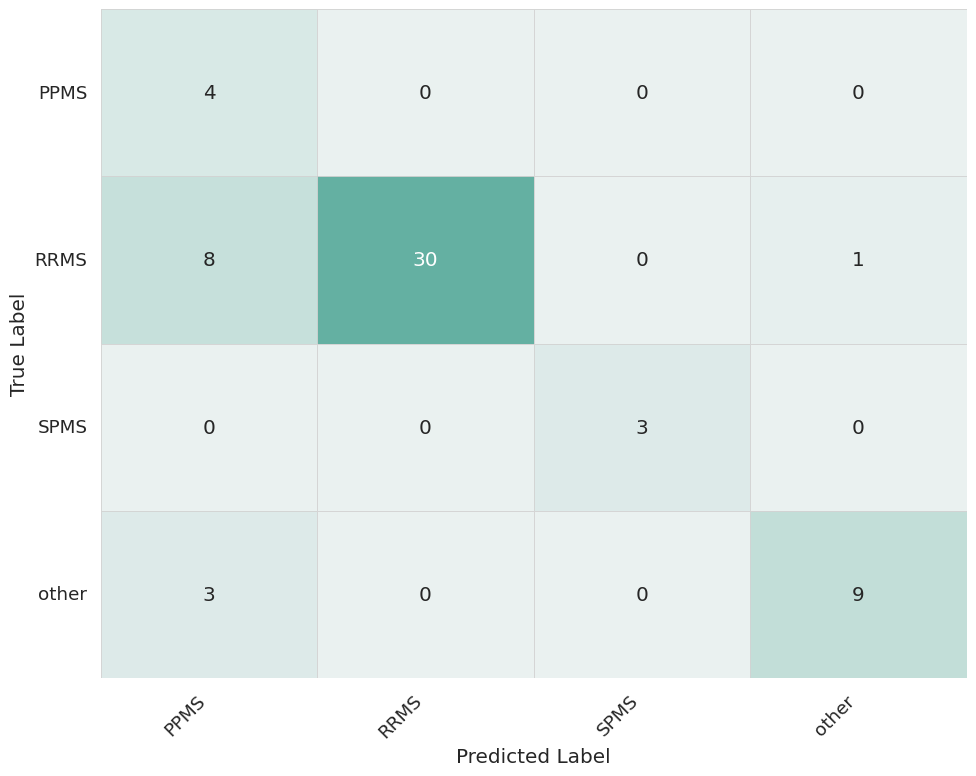

In [182]:
pretty_confusion_matrix(y_true = outputs["labels"], y_pred = outputs["preds"], labels = ["PPMS", "RRMS", "SPMS", "other"])

In [184]:
for label, pred, text in zip(*outputs.values()):
    if label != pred:
        print("Label :", label)
        print("Pred :", pred)
        print("Text: \n", text)

Label : 1
Pred : 0
Text: 
 Schubförmig-remittierende Multiple Sklerose, EM und ED 04/2007
INDENT Diagnostik
INDENT EDSS 05/2019: 2.0
INDENT MRI-Neuroachse 08/2018: Intrakraniell sowie spinal kein Nachweis von neuen oder KM-aufnehmenden Läsionen
INDENT MRI Schädel vom 08/2013: 1 neue gliotische Läsion im Übergang Mittelhirn zu oberem Kleinhirnschenkel der linken Seite
INDENT MRI Neuroachse vom 09/2012: Fraglich neue Läsion im Centrum semiovale post rechts, ansonsten stabiler Befund zerebral. Spinal fragliche Progredienz der Läsionen des thorakalen Myelons
INDENT Sensomotorisches Querschnittsyndrom, sensibel: sub-Th1, rechts-betont sowie distal-betont an allen Extremitäten, motorische Parese Kleinfinger rechts 04/2007
INDENT MRI Schädel vom 04/2007: ausgedehnt KM-aufnehmende Läsion C1-3, 2 kleine Läsionen obere u. untere BWS; multiple (> 20), nicht KM-aufnehmende periventrikuläre T2-Läsionen 
INDENT Liquor 04/2007: Zellzahl 8/µlL Protein 0,48 g/L, IgG-Index 1.44, OKB positiv
INDENT Thera

In [183]:
check_gpu_memory()

GPU 0: NVIDIA GeForce RTX 3090
   Total Memory: 23.69 GB
   Free Memory: 2.95 GB
   Allocated Memory : 6.92 GB
   Reserved Memory : 19.43 GB


In [155]:
# ms_data_diag = load_ms_data("line")["test"].filter(lambda e: e["labels"] != 3)
# ms_data_no_diag = load_ms_data("line")["test"].filter(lambda e: e["labels"] == 3).select(range(15))
# ms_data = concatenate_datasets([ms_data_diag, ms_data_no_diag])
ms_data = load_ms_data("line")["test"]

In [156]:
inputs = [zero_shot_instruction(text) for text in ms_data["text"]]
test_loader = DataLoader(inputs, batch_size = 4, shuffle = False)

sampler = samplers.greedy()

generator = outlines.generate.choice(model, ["primär progrediente Multiple Sklerose (PPMS)",
                                             "sekundär progrediente Multiple Sklerose (SPMS)",
                                            "schubförmig remittierende Multiple Sklerose (RRMS)",
                                            "not enough info"], sampler=sampler)

In [157]:
results = []
for batch in tqdm(test_loader):
    answer = generator(batch)
    results.extend(answer)

100%|██████████| 263/263 [24:22<00:00,  5.56s/it]


In [158]:
label_mappings = dict(zip(["primär progrediente Multiple Sklerose PPMS",
                                             "sekundär progrediente Multiple Sklerose SPMS",
                                            "schubförmig remittierende Multiple Sklerose RRMS",
                                            "not enough info"], [0,2,1,3]))

In [159]:
results_mapped = [label_mappings[pred] for pred in results]

In [174]:
outputs = {"labels": ms_data["labels"], "preds":results_mapped, "text": ms_data["text"]}
torch.save(outputs, paths.RESULTS_PATH/"ms-diag"/"ms-diag_Llama2-MedTuned-13b_4bit_line_instruction_outlines")

In [164]:
print(classification_report(y_true = outputs["labels"], y_pred = outputs["preds"]))

              precision    recall  f1-score   support

           0       0.05      1.00      0.10         4
           1       0.61      0.95      0.74        39
           2       0.75      1.00      0.86         3
           3       1.00      0.91      0.95      1004

    accuracy                           0.91      1050
   macro avg       0.60      0.96      0.66      1050
weighted avg       0.98      0.91      0.94      1050



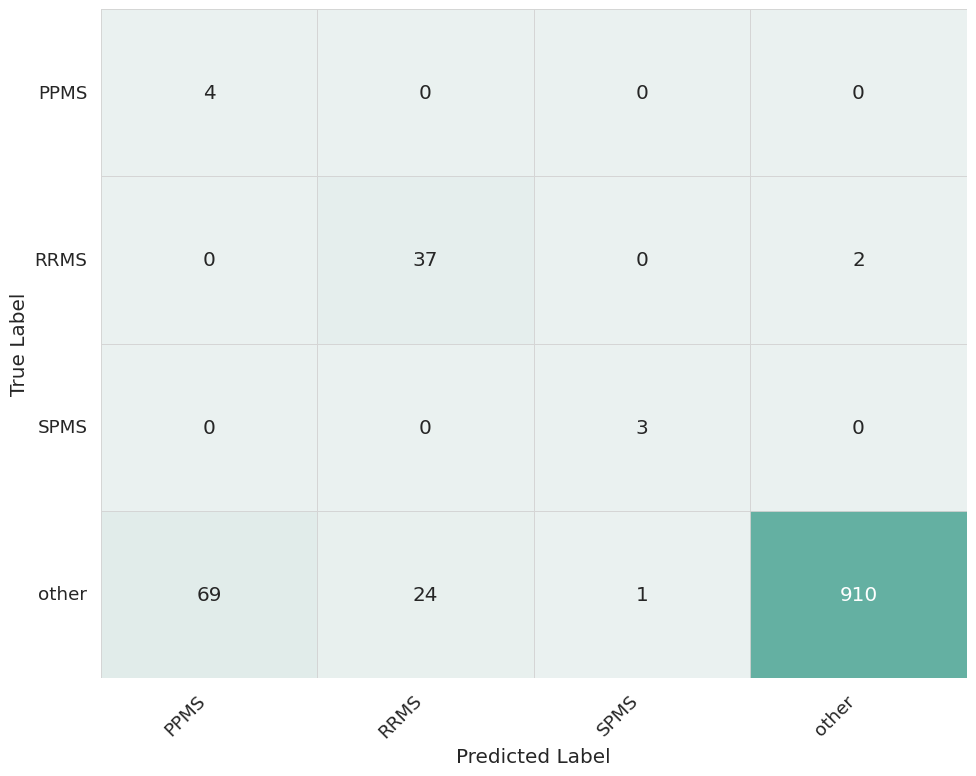

In [165]:
pretty_confusion_matrix(y_true = outputs["labels"], y_pred = outputs["preds"], labels = ["PPMS", "RRMS", "SPMS", "other"])

In [173]:
for label, pred, text in zip(*outputs.values()):
    if label != pred:
        print("Label :", label)
        print("Pred :", pred)
        print("Text: \n", text)

Label : 3
Pred : 0
Text: 
 INDENT - aktuell: beschwerdefrei
Label : 3
Pred : 0
Text: 
 INDENT - 10/2013 MRI cerebral/ spinal: Im Myelon zeigen sich 3 zervikale und 4 thorakale Läsionen, grösste Läsion auf Höhe HWK2 umfasst nahezu die dorsalen 2/3, ist ödematös und weist ein diskretes Enhancement auf. Zwei neu aufgetretene Herde einer mit Kontrastmittelenhancement subependymal links am Truncus des Corpus callosum, der zweite ohne Aktivität im Forceps minor links. Flaue Läsion in der Medulla oblongata mit fraglichem Enhancement. Ansonsten intrakraniellen Herde stationär ohne Aktivität. 
Label : 3
Pred : 0
Text: 
 INDENT Klinik
Label : 3
Pred : 1
Text: 
 INDENT 28.09.14: Neuritis nervi optici rechts - Remittiert bis ca. 11/14
Label : 3
Pred : 1
Text: 
 INDENT ca. 12/14: anamnestisch Neuritis nervi optici links - komplett remittiert
Label : 3
Pred : 0
Text: 
 Anamnestisch:
Label : 3
Pred : 0
Text: 
 Klinisch: 
Label : 3
Pred : 1
Text: 
 INDENT 04/2017: Fraglicher Schub bei beidseitiger Vis

# Testing